# Computational Tests

This notebook is intended for running different kinds of analyses that would validate our reconstruction.

[1. Subsystem Overview and Analysis](#subsystems) <br>
[2. Context-specific Model Generation](#context_specific) <br>
[3. Biomass prediction using exp. data](#biomass) <br>
[4. Flux Enrichment Analysis](#fea) <br>

## 1. Subsystem Overview and Analysis <a id='subsystems'></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from google_sheet import GoogleSheet

In [ ]:
##### ----- Generate Subsystems datasets from Google Sheet ----- #####

#Credential file
KEY_FILE_PATH = 'credentials.json'

#CHO Network Reconstruction + Recon3D_v3 Google Sheet ID
SPREADSHEET_ID = '1MlBXeHIKw8k8fZyXm-sN__AHTRSunJxar_-bqvukZws'

# Initialize the GoogleSheet object
sheet = GoogleSheet(SPREADSHEET_ID, KEY_FILE_PATH)

# Read data from the Google Sheet
sheet_subsystems = 'Summary Systems'
subsystems = sheet.read_google_sheet(sheet_subsystems)

# Remove the total count
subsystems = subsystems.iloc[:-1, :]

In [ ]:
#### --- Pie Chart of the Amount of Reactions per System --- ####

subsystems["Number of Reactions"] = pd.to_numeric(subsystems["Number of Reactions"])

# Aggregate data by "System" and sum "Number of Reactions"
system_reactions = subsystems.groupby("System")["Number of Reactions"].sum()

# Set the figure and axes for more control
fig, ax = plt.subplots(figsize=(10, 7))

# Generate the pie chart again with the custom labels
patches, texts, autotexts = ax.pie(system_reactions, labels=system_reactions.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', startangle=140, colors=plt.cm.tab20.colors)

# Improve aesthetics
for text in texts + autotexts:
    text.set_color('black')
ax.set_title("Pie Chart of Number of Reactions by System", pad=30)  # Move the title upwards by increasing pad

# Set equal aspect ratio
ax.axis('equal')

# Save the plot
plt.savefig('../Plots/pie_chart_reactions_per_system.png')

# Display the plot
plt.show()

In [ ]:
# Generate the Sunburst Plot

fig = px.sunburst(subsystems, path=['System', 'Subsystems', 'Kegg Pathway'],
                  color='System')

# Convert to a Graph Objects figure
fig_go = go.Figure(fig)

# Update layout
fig_go.update_layout(width=1200, height=1000)

# Define font sizes
font_size_last_layer = 10
font_size_previous_layer = 15
default_font_size = 12

# Create a list to store font sizes
font_sizes = []

# Update font size for each level
for trace in fig_go.data:
    if isinstance(trace, go.Sunburst):
        for id in trace.ids:
            level = id.count("/")  # Determine level by the number of slashes in the id
            if level == 2:  # Last layer (Kegg Pathway)
                font_sizes.append(font_size_last_layer)
            elif level == 1:  # Previous layer (Subsystems)
                font_sizes.append(font_size_previous_layer)
            else:
                font_sizes.append(default_font_size)  # Default size for other layers

# Apply the font sizes to the figure
fig_go.update_traces(insidetextfont=dict(size=font_sizes))

# Save the figure
fig_go.write_html("../Plots/sunburst_subsystems.html")  # Save as interactive HTML file
fig_go.write_image("../Plots/sunburst_subsystems.png", width=1200, height=1000, scale=2)  # Increase resolution by setting scale parameter

# Show the plot
fig_go.show()

#### Auxotrophies

In [ ]:
from cobra.io import load_json_model

iCHO_path = "iCHO3595.json"
iCHO = load_json_model(iCHO_path)

In [ ]:
amino_acids = {
    "arginine": ["EX_arg_L_e", "EX_arg_D_e"],
    "asparagine": ["EX_asn_L_e", "EX_asn_D_e"],
    "cysteine": ["EX_cys_L_e", "EX_cys_D_e", "EX_Lcystin_e"],
    "histidine": ["EX_his_L_e", "EX_his_D_e"],
    "isoleucine": ["EX_ile_L_e", "EX_ile_D_e"],
    "leucine": ["EX_leu_L_e", "EX_leu_D_e"],
    "lysine": ["EX_lys_L_e", "EX_lys_D_e"],
    "methionine": ["EX_met_L_e", "EX_met_D_e"],
    "phenylalanine": ["EX_phe_L_e", "EX_phe_D_e"],
    "proline": ["EX_pro_L_e", "EX_pro_D_e"],
    "threonine": ["EX_thr_L_e", "EX_thr_D_e"],
    "tryptophan": ["EX_trp_L_e", "EX_trp_D_e"],
    "valine": ["EX_val_L_e", "EX_val_D_e"]
}
for amino_acid in amino_acids:
    # ----- Setup initial bounds -----
    for exchange_reaction in iCHO.exchanges:
        exchange_reaction.bounds = -10, 10

    # Arginine
    iCHO.reactions.get_by_id('GAUGE-R00557').bounds = 0, 10
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R00558').bounds = 0, 0
    iCHO.reactions.get_by_id('GLYAMDTRc').bounds = 0, 0
    iCHO.reactions.get_by_id('GAUGE-R10107').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('ARGSL').bounds = 0, 0

    # Asparigine
    iCHO.reactions.get_by_id('ASNS1').bounds = 0, 0

    # Cysteine
    iCHO.reactions.get_by_id('r0129').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_cgly_e').bounds = 0, 0
    iCHO.reactions.get_by_id('AMPTASECG').bounds = -10, 0
    iCHO.reactions.get_by_id('AMPTASECGe').bounds = -10, 0
    iCHO.reactions.get_by_id('CYSTGL').bounds = -10, 0
    iCHO.reactions.get_by_id('EX_HC00250_e').bounds = 0, 0
    iCHO.reactions.get_by_id('EX_sfcys_e').bounds = 0, 0

    # Histidine
    iCHO.reactions.get_by_id('VALTRPVALr').bounds = 0,0 

    # Isoleucine - DONE
    iCHO.reactions.get_by_id('EX_CE2916_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_CE2915_e').bounds = 0,0 
    iCHO.reactions.get_by_id('ILETA').bounds = 0, 10
    iCHO.reactions.get_by_id('ILETAm').bounds = 0, 10

    # Leucine
    iCHO.reactions.get_by_id('LEULEULAPc').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_leugly_e').bounds = 0,0 
    iCHO.reactions.get_by_id('EX_glyleu_e').bounds = 0,0 
    iCHO.reactions.get_by_id('LEUTA').bounds = 0, 10 
    iCHO.reactions.get_by_id('LEUTAm').bounds = 0, 10 
    iCHO.reactions.get_by_id('EX_CE5797_e').bounds = 0, 0

    # Lysine
    iCHO.reactions.get_by_id('EX_biocyt_e').bounds = 0,0 

    # Methionine
    iCHO.reactions.get_by_id('METS').bounds = -10, 0 
    iCHO.reactions.get_by_id('BHMT').bounds = -10, 0 
    iCHO.reactions.get_by_id('GAUGE-R00648').bounds = 0, 10 
    iCHO.reactions.get_by_id('UNK2').bounds = -10, 0 
    iCHO.reactions.get_by_id('UNK3').bounds = -10, 0 
    iCHO.reactions.get_by_id('TYRA').bounds = -10, 0 
    #iCHO.reactions.get_by_id('GAUGE-R06895').bounds = 0, 0 # Curated by MR with 1 score / Erased from the reconstruction

    # Phenylalanine
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_pheleu_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_glyphe_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE2917_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5786_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_CE5789_e').bounds = 0, 0 
    iCHO.reactions.get_by_id('EX_phpyr_e').bounds = 0, 0 

    # Proline
    iCHO.reactions.get_by_id('EX_glypro_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_progly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('P5CR').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRxm').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRx').bounds = 0, 0
    iCHO.reactions.get_by_id('P5CRm').bounds = 0, 0
    iCHO.reactions.get_by_id('r1453').bounds = 0, 10

    # Threonine
    #iCHO.reactions.get_by_id('THRS').bounds = 0,0  # Erased from the reconstruction


    # Tryptophan
    iCHO.reactions.get_by_id('NBAHH_ir').bounds = 0,0  # Histidine hydrolase

    # Valine
    iCHO.reactions.get_by_id('EX_valarggly_e').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_vallystyr_e').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTA').bounds = 0, 10
    iCHO.reactions.get_by_id('VALTAm').bounds = 0, 10
    iCHO.reactions.get_by_id('EX_valval_e').bounds = 0, 10
    # -----------------------------------------

    for exchange_reaction in iCHO.exchanges:
        if exchange_reaction.id in amino_acids[amino_acid]:
            exchange_reaction.bounds = 0, 10
            # print(amino_acid, exchange_reaction.id, amino_acids[amino_acid])
    sol = iCHO.optimize()
    print(amino_acid, sol.objective_value)


In [ ]:
iCHO.metabolites.leu_L_c.summary()

#### Matrix Sparsity

In [ ]:
import cobra
import numpy as np
S = cobra.util.create_stoichiometric_matrix(iCHO)
total_elements = S.size
zero_elements = np.count_nonzero(S == 0)
sparsity = zero_elements / total_elements

print(f"Sparsity of the stoichiometric matrix: {sparsity:.2%}")
# The less sparse the better
# Compare to other recons

#### Gene Deletion test

In [ ]:
import pandas as pd
from cobra.io import load_json_model, read_sbml_model
from cobra.flux_analysis import single_gene_deletion

#iCHO = load_json_model('iCHO3595_unblocked.json')
#iCHO1766 = read_sbml_model('../Data/Reconciliation/models/iCHOv1_final.xml')
iCHO2291 = read_sbml_model('../Data/Reconciliation/models/iCHO2291.xml')
#iCHO2441 = read_sbml_model('../Data/Reconciliation/models/iCHO2441.xml')

In [ ]:
gene_deletion_results = single_gene_deletion(iCHO2291)
essentiality_threshold = 0.01
essential_genes = gene_deletion_results[gene_deletion_results['growth'] < essentiality_threshold]

In [ ]:
# Print the essential genes
print(f"Number of essential genes for biomass: {len(essential_genes)}")
print("Essential genes for biomass production:")
for gene_idx in essential_genes.index:
    gene = iCHO2291.genes[gene_idx]
    print(f"{gene.id}: {gene.name}")

In [ ]:
from cobra.flux_analysis.variability import find_essential_genes

In [ ]:
sim_essential_genes = find_essential_genes(model)

In [ ]:
# Load the dataset for the experimentally validated essential genes

exp_essential_genes = pd.read_csv('../Data/Gene_Essentiality/cho_essential_genes.csv', sep='\t')
exp_essential_genes['gene'] = exp_essential_genes['gene'].str.replace('__1$', '', regex=True)

In [ ]:
exp_essential_genes

In [ ]:
# Extract all gene names
all_gene_names = set()
for names in exp_essential_genes['gene']:
    for name in names.split('|'): #Extract the names of the genes with two aliases
        all_gene_names.add(name)

In [ ]:
essential_genes_model = []
for g in model.genes:
    if g.name in all_gene_names:
        essential_genes_model.append(g)

In [ ]:
set1 = set(sim_essential_genes)
set2 = set(essential_genes_model)

# Find shared elements
shared_elements = set1.intersection(set2)

# Find unique elements
unique_in_list1 = set1.difference(set2)
unique_in_list2 = set2.difference(set1)

In [ ]:
print("Shared genes between Exp Validated Essential Genes and Simulated Essential Genes:", len(shared_elements))
print("Unique genes in Simulated Essential Genes:", len(unique_in_list1))
print("Unique genes in Exp Validated Essentail Genes:", len(unique_in_list2))

##### Essential for growth genes and comparison to (An optimised genome-wide, virus free CRISPR screen for mammalian cells)
https://pubmed.ncbi.nlm.nih.gov/34935002/

## 2. Context-specific Model Generation <a id='context_specific'></a>

Here we use a matrix generated with rmf_CADRE to generate each context_specific model for each one of the conditions.

In [ ]:
import scipy.io
from cobra.io import load_json_model, save_json_model

In [ ]:
# Load the matrix
matrix = scipy.io.loadmat('../Data/Context_specific_models/CHO_retained_reactions.mat')['retR']

# Load conditions
conditions = open('../Data/Context_specific_models/uniqueConditions.txt', 'r').read().strip().split(',')

# Load model
model = load_json_model('iCHO3595_unblocked.json')

In [ ]:
# Iterate over each condition to generate a context-specific model for each one

for i, condition in enumerate(conditions):
    
    # Create a copy of the model for each condition
    submodel = model.copy()
    
    # Assign a unique name based on the condition index
    submodel.id = condition
    
    # List to collect reactions to remove
    reactions_to_remove = [submodel.reactions[j].id for j in range(matrix.shape[0]) if matrix[j, i] == 0]
    
    # Remove the collected reactions from the submodel
    submodel.remove_reactions(reactions_to_remove, remove_orphans=False)

    # Save each model as JSON with a unique name based on the condition
    model_name_json = f'../Data/Context_specific_models/iCHO_{condition}.json'
    save_json_model(submodel, model_name_json)
    
    print(f'Model {condition} generated, {i}')

## 3. Biomass prediction using exp. data <a id='biomass'></a>

Here we incorporate uptake and secretion rates from (https://www.sciencedirect.com/science/article/pii/S2405471216303635?via%3Dihub) data and calculate the growth rate (Figure 3). Reproduce Hooman's analsys with iCHO_v1 and incorporate iCHO2291 and iCHO2441 into the analysis.

To do:
- Try ecFBA with enzyme trunover numbers.

In [1]:
import os
import pickle
import pandas as pd

import cobra
from cobra.io import load_json_model, read_sbml_model, load_matlab_model
from cobra.exceptions import Infeasible

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model = load_json_model('iCHO3595_unblocked.json')
#model = load_matlab_model('../Data/Context_specific_models/Reduced models/reduced_model_S2.mat')


model.solver = 'gurobi'
objective = 'biomass_cho_s' # 'biomass_cho'
model.objective = objective

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04


In [3]:
# Load uptake and secretion rate dict

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_wt_dict.pkl', 'rb') as file:
    uptsec_wt = pickle.load(file)

with open('../Data/Uptake_Secretion_Rates/uptake_secretion_raw_zela_dict.pkl', 'rb') as file:
    uptsec_zela = pickle.load(file)

In [4]:
# Sanity Check. Make sure all the exchange reactions in the experimental data are present in the model

exchanges = list(uptsec_wt.keys())
model_ex = [r.id for r in model.boundary]

for ex in exchanges:
    if ex not in model_ex:
        print(ex)

exp_growth_rate


In [6]:
# WT

results = []

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
replicates = ['U1', 'U2', 'U3']

with model:
    # Set lower bounds of the reactions according to the experimental data
    for itrvl in intervals:
        # Iterate over each replicate
        for rep in replicates:
            # Reset model boundaries in each iteration
            for rxn in model.boundary:
                if rxn.id.startswith("EX_"):
                    rxn.bounds = (0,1000) 
                if rxn.id.startswith("SK_"):
                    rxn.bounds = (-1000,1000)
                if rxn.id.startswith("DM_"):
                    rxn.bounds = (0,1000)
                if rxn.id == 'SK_23camp_l':
                    rxn.bounds = (-0.014,0)
            
            print(f'Calculating Growth Rate for WT Condition:{rep,itrvl}')
            exp_gr = uptsec_wt['exp_growth_rate'][(rep,itrvl)]
            print(f'Experimental growth rate is: {exp_gr}')
            for reaction in model.reactions:
                if reaction.id == 'EX_etoh_e': #Model creates infeasible solutions when secreting etoh
                    continue
                for r,v in uptsec_wt.items():
                    if reaction.id == r:
                        reaction.lower_bound = v[(rep,itrvl)]
            try:
                pfba_solution = cobra.flux_analysis.pfba(model)
                pfba_obj = pfba_solution.fluxes[objective]
                print(f'Simulated growth rate is: {pfba_obj}')
                results.append([rep, itrvl, exp_gr, pfba_obj])
            except Infeasible:
                print(f'Infeasible solution for replicate {rep} interval {itrvl}')
                if itrvl == 'P0 to P2':
                    continue
                    #model.reactions.EX_arg_L_e.lower_bound = -0.030
                    #model.reactions.EX_gln_L_e.lower_bound = -0.6
                    #model.reactions.EX_his_L_e.lower_bound = -0.02
                    #model.reactions.EX_4hpro_e.lower_bound = -0.02
                    model.reactions.EX_ile_L_e.lower_bound = -0.04
                    model.reactions.EX_leu_L_e.lower_bound = -0.06
                    model.reactions.EX_lys_L_e.lower_bound = -0.03
                    odel.reactions.EX_met_L_e.lower_bound = -0.015
                    model.reactions.EX_phe_L_e.lower_bound = -0.015
                    model.reactions.EX_tyr_L_e.lower_bound = -0.015
                    pfba_solution = model.optimize()
                    pfba_obj = pfba_solution.fluxes[objective]
                    print(f'Simulated growth rate is: {pfba_obj}')
                    results.append([rep, itrvl, exp_gr, pfba_obj])

# Creating a DataFrame
df_wt = pd.DataFrame(results, columns=['Hue', 'Category', 'X Axis', 'Y Axis'])

Calculating Growth Rate for WT Condition:('U1', 'P0 to P2')
Experimental growth rate is: 0.034670390416558304
Infeasible solution for replicate U1 interval P0 to P2
Calculating Growth Rate for WT Condition:('U2', 'P0 to P2')
Experimental growth rate is: 0.03650816079097704
Infeasible solution for replicate U2 interval P0 to P2
Calculating Growth Rate for WT Condition:('U3', 'P0 to P2')
Experimental growth rate is: 0.03601395792194038
Infeasible solution for replicate U3 interval P0 to P2
Calculating Growth Rate for WT Condition:('U1', 'P2 to P4')
Experimental growth rate is: 0.03278062118952783
Simulated growth rate is: 0.03470089046946774
Calculating Growth Rate for WT Condition:('U2', 'P2 to P4')
Experimental growth rate is: 0.033990046589398894
Simulated growth rate is: 0.034700890469465354
Calculating Growth Rate for WT Condition:('U3', 'P2 to P4')
Experimental growth rate is: 0.035978739841978656
Simulated growth rate is: 0.03470089046946171
Calculating Growth Rate for WT Conditio

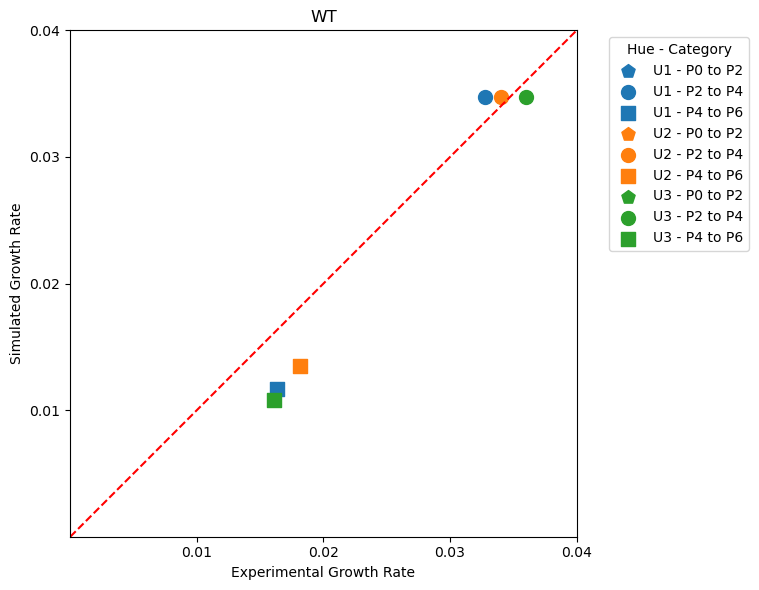

In [7]:
df =df_wt
# Define markers for categories
markers = {
    'P0 to P2': 'p',  # Circle
    'P2 to P4': 'o',  # Circle
    'P4 to P6': 's',   # Square
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each group with different colors for hue and different shapes for categories
hues = df['Hue'].unique()
colors = plt.colormaps.get_cmap('tab10')

for hue_idx, hue in enumerate(hues):
    hue_subset = df[df['Hue'] == hue]
    for category, marker in markers.items():
        subset = hue_subset[hue_subset['Category'] == category]
        plt.scatter(subset['X Axis'], subset['Y Axis'], label=f'{hue} - {category}', marker=marker, s=100, color=colors(hue_idx))

# Add the identity line y = x
plt.plot([0.00, 0.04], [0.00, 0.04], color='red', linestyle='--')

# Set evenly distributed ticks from 0.01 to 0.08
ticks = [i / 100.0 for i in range(1, 9)]
plt.xticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 9)])
plt.yticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 9)])

# Set limits for both axes
plt.xlim(0.0, 0.04)
plt.ylim(0.0, 0.04)

# Setting the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Adding labels and title
plt.xlabel('Experimental Growth Rate')
plt.ylabel('Simulated Growth Rate')
plt.title('WT')
plt.legend(title='Hue - Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [12]:
# ZeLa

results = []

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
intervals = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
replicates = ['U4', 'U5', 'U6', 'U7', 'U8']

with model:
    # Set lower bounds of the reactions according to the experimental data
    for itrvl in intervals:
        # Iterate over each replicate
        for rep in replicates:
            # Reset model boundaries in each iteration
            for rxn in model.boundary:
                if rxn.id.startswith("EX_"):
                    rxn.bounds = (0,1000) 
                if rxn.id.startswith("SK_"):
                    rxn.bounds = (-1000,1000)
                if rxn.id.startswith("DM_"):
                    rxn.bounds = (0,1000)
                if rxn.id == 'SK_23camp_l':
                    rxn.bounds = (-0.014,0)
            
            print(f'Calculating Growth Rate for WT Condition:{rep,itrvl}')
            exp_gr = uptsec_zela['exp_growth_rate'][(rep,itrvl)]
            print(f'Experimental growth rate is: {exp_gr}')
            for reaction in model.reactions:
                if (reaction.id == 'EX_etoh_e'): #Model creates infeasible solutions when secreting etoh
                    continue
                for r,v in uptsec_zela.items():
                    if reaction.id == r:
                        reaction.lower_bound = v[(rep,itrvl)]
            try:
                pfba_solution = cobra.flux_analysis.pfba(model)
                pfba_obj = pfba_solution.fluxes[objective]
                print(f'Simulated growth rate is: {pfba_obj}')
                results.append([rep, itrvl, exp_gr, pfba_obj])
            except Infeasible:
                print(f'Infeasible solution for replicate {rep} interval {itrvl}')
                if itrvl == 'P0 to P2':
                    continue
                    model.reactions.EX_phe_L_e.lower_bound = -0.015
                    pfba_solution = cobra.flux_analysis.pfba(model)
                    pfba_obj = pfba_solution.fluxes[objective]
                    print(f'Simulated growth rate is: {pfba_obj}')
                    results.append([rep, itrvl, exp_gr, pfba_obj])
    
    # Creating a DataFrame
    df_zela = pd.DataFrame(results, columns=['Hue', 'Category', 'X Axis', 'Y Axis'])

Calculating Growth Rate for WT Condition:('U4', 'P0 to P2')
Experimental growth rate is: 0.03194602306128404
Infeasible solution for replicate U4 interval P0 to P2
Calculating Growth Rate for WT Condition:('U5', 'P0 to P2')
Experimental growth rate is: 0.03465754637187661
Simulated growth rate is: 0.034700890469464805
Calculating Growth Rate for WT Condition:('U6', 'P0 to P2')
Experimental growth rate is: 0.03857293418595174
Simulated growth rate is: 0.026654425421040573
Calculating Growth Rate for WT Condition:('U7', 'P0 to P2')
Experimental growth rate is: 0.036350210065094826
Simulated growth rate is: 0.00204423999425336
Calculating Growth Rate for WT Condition:('U8', 'P0 to P2')
Experimental growth rate is: 0.03509821565744508
Infeasible solution for replicate U8 interval P0 to P2
Calculating Growth Rate for WT Condition:('U4', 'P2 to P4')
Experimental growth rate is: 0.036151474706364185
Simulated growth rate is: 0.034700890469466374
Calculating Growth Rate for WT Condition:('U5',

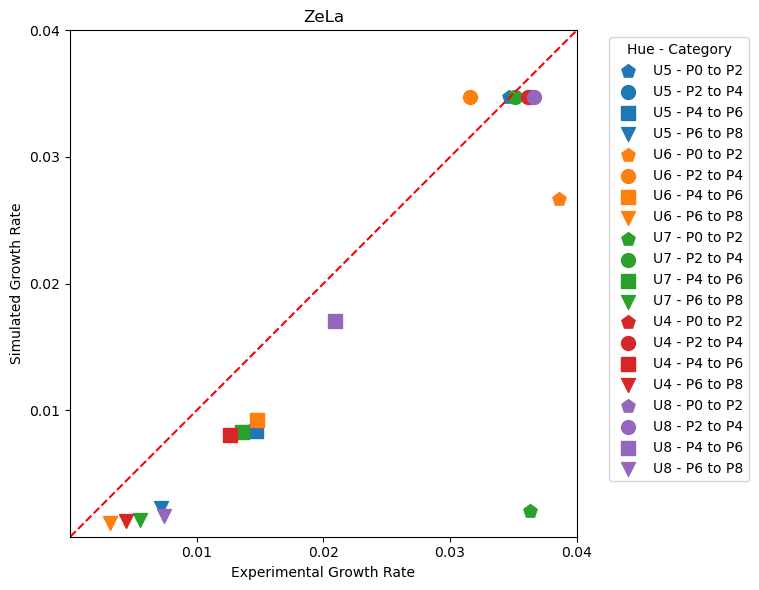

In [13]:
df =df_zela
# Define markers for categories
markers = {
    'P0 to P2': 'p',
    'P2 to P4': 'o',  # Circle
    'P4 to P6': 's',   # Square
    'P6 to P8': 'v',
}

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot each group with different colors for hue and different shapes for categories
hues = df['Hue'].unique()
colors = plt.colormaps.get_cmap('tab10')

for hue_idx, hue in enumerate(hues):
    hue_subset = df[df['Hue'] == hue]
    for category, marker in markers.items():
        subset = hue_subset[hue_subset['Category'] == category]
        plt.scatter(subset['X Axis'], subset['Y Axis'], label=f'{hue} - {category}', marker=marker, s=100, color=colors(hue_idx))

# Add the identity line y = x
plt.plot([0.00, 0.04], [0.00, 0.04], color='red', linestyle='--')

# Set evenly distributed ticks from 0.01 to 0.08
ticks = [i / 100.0 for i in range(1, 9)]
plt.xticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 9)])
plt.yticks(ticks=ticks, labels=[f'{i/100.0:.2f}' for i in range(1, 9)])

# Set limits for both axes
plt.xlim(0.0, 0.04)
plt.ylim(0.0, 0.04)

# Setting the same scale for both axes
plt.gca().set_aspect('equal', adjustable='box')

# Adding labels and title
plt.xlabel('Experimental Growth Rate')
plt.ylabel('Simulated Growth Rate')
plt.title('ZeLa')
plt.legend(title='Hue - Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
for reaction, values in uptsec_zela.items():
    plt.figure(figsize=(10, 6))
    
    # Organize data for plotting
    batches = sorted(set(k[0] for k in values.keys()))
    timepoints = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
    
    for batch in batches:
        batch_data = [values.get((batch, tp), 0) for tp in timepoints]
        plt.plot(timepoints, batch_data, marker='o', label=batch)
    
    plt.title(f'Changes in {reaction} over time')
    plt.xlabel('Timepoints')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [ ]:
for reaction, values in uptsec_wt.items():
    plt.figure(figsize=(10, 6))
    
    # Organize data for plotting
    batches = sorted(set(k[0] for k in values.keys()))
    timepoints = ['P0 to P2', 'P2 to P4', 'P4 to P6', 'P6 to P8', 'P8 to P12', 'P12 to P14']
    
    for batch in batches:
        batch_data = [values.get((batch, tp), 0) for tp in timepoints]
        plt.plot(timepoints, batch_data, marker='o', label=batch)
    
    plt.title(f'Changes in {reaction} over time')
    plt.xlabel('Timepoints')
    plt.ylabel('Values')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [ ]:
for rxn in model.boundary:
    # IMPORTANT, all ex should be 0 - 1000, except those that we know are being uptaken by the cell

    if rxn.id.startswith("EX_"):
        rxn.bounds = (0,1000) 
    if rxn.id.startswith("SK_"):
        rxn.bounds = (-1000,1000)
    if rxn.id.startswith("DM_"):
        rxn.bounds = (0,1000)

# Adjust the lower bound values according to the experimental growth rates in order to indetify bottlenecks
cond = 'P0 to P2'

pfba_solution = cobra.flux_analysis.pfba(model)
pfba_obj = pfba_solution.fluxes[objective]
print(f'Before changing any bounds simulated growth rate is: {pfba_obj}')

# Set lower bounds of the reactions according to the experimental data
for reaction in model.reactions:
    if reaction.id == 'biomass_cho_s':
        continue
    for r,v in uptsec_wt.items():
        if reaction.id == r:
            if not pd.isna(v[cond]):
                reaction.lower_bound = v[cond]
                #if reaction.id == 'EX_arg_L_e':
                #    reaction.lower_bound = -0.0107
                #if reaction.id == 'EX_his_L_e':
                #    reaction.lower_bound = -0.00314
                print(f'Reaction {r} setting bounds to {reaction.bounds}')
                try:
                    pfba_solution = cobra.flux_analysis.pfba(model)
                    pfba_obj = pfba_solution.fluxes[objective]
                    print(f'Simulated growth rate is: {pfba_obj}')
                except Infeasible:
                    print(f'Changing bounds for reaction {r} to {reaction.bounds} creates an infeasible solution')
                    reaction.lower_bound = -1000

In [ ]:
# Load libraries
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import cobra
from cobra.io import load_json_model, read_sbml_model

In [ ]:
# Define models

iCHO1766 = read_sbml_model('../Data/Reconciliation/models/iCHOv1_final.xml')
iCHO2291 = read_sbml_model('../Data/Reconciliation/models/iCHO2291.xml')
iCHO2441 = read_sbml_model('../Data/Reconciliation/models/iCHO2441.xml')
iCHO3000 = load_json_model('iCHO3644.json')

In [ ]:
# Preprocess and standarization of iCHO1766
iCHO1766.id = 'iCHO1766'
iCHO1766.reactions.biomass_cho_producing.id = 'biomass_cho_prod'
for r in iCHO1766.reactions:
    if r.id.endswith("_"):
        r.id = r.id[:-1]

# Preprocess and standarization of iCHO2101
iCHO2441.id = 'iCHO2441'
for r in iCHO2441.reactions:
    if r.id.endswith("(e)"):
        r.id = r.id.replace("(e)", "_e")
    if r.id == "SK_Asn_X_Ser/Thr[r]":
        r.id = "SK_Asn_X_Ser_Thr_r"
    if r.id == "SK_pre_prot[r]":
        r.id = "SK_pre_prot_r"
    if r.id == "SK_Ser/Thr[g]":
        r.id = "SK_Ser_Thr_g"
    if r.id == "SK_Tyr_ggn[c]":
        r.id = "SK_Tyr_ggn_c"
    if r.id == "DM_igg[g]":
        r.id = "DM_igg_g"

# Preprocess and standarization of iCHO2291
for r in iCHO2291.reactions:
    if r.id.endswith("(e)"):
        r.id = r.id.replace("(e)", "_e")
    if r.id == "SK_Asn_X_Ser/Thr[r]":
        r.id = "SK_Asn_X_Ser_Thr_r"
    if r.id == "SK_pre_prot[r]":
        r.id = "SK_pre_prot_r"
    if r.id == "SK_Ser/Thr[g]":
        r.id = "SK_Ser_Thr_g"
    if r.id == "SK_Tyr_ggn[c]":
        r.id = "SK_Tyr_ggn_c"
    if r.id == "DM_igg[g]":
        r.id = "DM_igg_g"

In [ ]:
#models = [iCHO1766, iCHO2291, iCHO2441, iCHO3000]
models = [iCHO3000]

for model in models:
    model.reactions.biomass_cho.bounds = (0.0,10)
    model.reactions.biomass_cho_prod.bounds = (0.0,10)

In [ ]:
uptsec = pd.read_excel('../Data/Uptake_Secretion_Rates/mmc4.xlsx', header=2)

biomass_bounds = uptsec[42:44]
biomass_bounds = biomass_bounds.set_index(['Reaction'])

uptsec = uptsec[:-5]

In [ ]:
hp = uptsec.set_index('Reaction')['HP'].to_dict()
hp_nabu = uptsec.set_index('Reaction')['HP+NaBu'].to_dict()
lp = uptsec.set_index('Reaction')['LP'].to_dict()
lp_nabu = uptsec.set_index('Reaction')['LP+NaBu'].to_dict()
early_exp = uptsec.set_index('Reaction')['Early Exp'].to_dict()
late_exp = uptsec.set_index('Reaction')['Late Exp'].to_dict()
cold_1 = uptsec.set_index('Reaction')['Cold 1'].to_dict()
cold_2 = uptsec.set_index('Reaction')['Cold 2'].to_dict()

conditions = ['HP', 'HP+NaBu', 'LP', 'LP+NaBu', 'Early Exp', 'Late Exp', 'Cold 1', 'Cold 2']
dicts = [hp, hp_nabu, lp, lp_nabu, early_exp, late_exp, cold_1, cold_2]

In [ ]:
for model in models:
    for rxn in model.boundary:
    
        # IMPORTANT, all ex should be 0 - 1000, except those that we know are being uptaken by the cell
        
        if rxn.id.startswith("EX_"):
            rxn.bounds = (0,1000) 
        if rxn.id.startswith("SK_"):
            rxn.bounds = (-1000,1000)
        if rxn.id.startswith("DM_"):
            rxn.bounds = (0,1000)

In [ ]:
pfba_solutions_fluxes = []

df = pd.DataFrame(columns=["Model", "Condition", "Biomass_CHO", "Biomass_CHO_Prod"])

for model in models:

    model_data = []
    
    for cond,dic in zip(conditions,dicts):
        
        # Set lower bounds of the reactions according to the experimental data
        for reaction in model.reactions:
            for r,v in dic.items():
                if reaction.id == r:
                    if not pd.isna(v):
                        reaction.lower_bound = v
    
        # Calculate growth rate for each condition
        print('----------------------')
        print(f' Condtion: {cond} ')
        print('----------------------')

        # Print experimental growth rate
        exp_gr = biomass_bounds[cond]['Experimental growth rate']
        print(f'Experimental Growth Rate: {exp_gr}')

        # Calculate growth for biomass_cho
        model.objective = model.reactions.biomass_cho
        model.reactions.biomass_cho_prod.upper_bound = 0
        model.reactions.biomass_cho.upper_bound = 1000
        pfba_solution = cobra.flux_analysis.pfba(model)
        pfba_solution_biomass_cho = pfba_solution.fluxes['biomass_cho']
        print(f'Model: {model.id}, Biomass: {pfba_solution_biomass_cho}')

        # Calculate growth for biomass_cho_prod
        model.objective = model.reactions.biomass_cho_prod
        model.reactions.biomass_cho_prod.upper_bound = 1000
        model.reactions.biomass_cho.upper_bound = 0
        pfba_solution = cobra.flux_analysis.pfba(model)
        pfba_solution_biomass_cho_prod = pfba_solution.fluxes['biomass_cho_prod']
        print(f'Model: {model.id}, Biomass Prod: {pfba_solution_biomass_cho_prod}')
        print(' ')

        # Save the solution with metadata
        pfba_solutions_fluxes.append({
            "model_id": model.id,
            "condition": cond,
            "type": "biomass_cho_prod",
            "fluxes": pfba_solution.fluxes
        })

        # Append the results to the model_data list
        model_data.append({
            'Model': model.id,
            'Condition': cond,
            'Biomass_CHO': pfba_solution_biomass_cho,
            'Biomass_CHO_Prod': pfba_solution_biomass_cho_prod,
        })


    # Convert the model_data list to a DataFrame and concatenate it with the main DataFrame
    model_df = pd.DataFrame(model_data)
    df = pd.concat([df, model_df], ignore_index=True)


# Add the experimental growth rate values to the dataset
exp_data = []

for cond,dic in zip(conditions,dicts):
    exp_gr = biomass_bounds[cond]['Experimental growth rate']

    exp_data.append({
            'Model': "Exp",
            'Condition': cond,
            'Biomass_CHO': exp_gr,
            'Biomass_CHO_Prod': exp_gr,
        })
exp_df = pd.DataFrame(exp_data)
df = pd.concat([df, exp_df], ignore_index=True)

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk") 

# Plotting for Biomass_CHO
plt.figure(figsize=(12, 7))
barplot_cho = sns.barplot(data=df, x="Condition", y="Biomass_CHO", hue="Model", palette="viridis")
plt.title("Growth Rate Calculated with the Biomass CHO Reaction")
plt.ylabel("Growth Rate (hr-1)")
plt.xlabel("Condition")
plt.xticks(rotation=45)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../Plots/bar_plot_growth_rate_biomass_cho.png')
plt.show()

# Plotting for Biomass_CHO_Prod
plt.figure(figsize=(12, 7))
barplot_cho_prod = sns.barplot(data=df, x="Condition", y="Biomass_CHO_Prod", hue="Model", palette="viridis")
plt.title("Growth Rate Calculated with the Biomass CHO Prod Reaction")
plt.ylabel("Growth Rate (hr-1)")
plt.xlabel("Condition")
plt.xticks(rotation=45)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../Plots/bar_plot_growth_rate_biomass_cho_prod.png')
plt.show()

## 4. Flux Enrichment Analysis <a id='fea'></a>

In [ ]:
# OPTION 1
# Use the fluxes from the growth rate calculations to filter reactions with fluxes
# Define a cut off for the flux ??? # Plot to visualization of the flux distribution
# Run Flux Enrichment Analysis on those reactions to see pathways enriched when optimized by biomass

In [ ]:
# OPTION 2
# Transcriptomic data from cell batches / biorreactiors
# Overlay this into the recons and extract the reactions associated to the genes
# Extract a reaction vector / 
# Run Flux Enrichment Analysis

In [ ]:
# R1 = g1 or (g2 and G3)
# r1 = max(r1, (min(g2, g3))
# r1 = sum(r1, min(g2, g3))
# GIMME 
# Use mCADRE

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def flux_enrichment_analysis(model, rxn_indices, attribute='subsystem'):
    # Ensure rxn_indices is a list of integers
    if not isinstance(rxn_indices, list) or not all(isinstance(i, int) for i in rxn_indices):
        raise ValueError('rxn_indices must be a list of integers')
    
    # Check if the attribute exists in the first reaction as a proxy for all
    if not hasattr(model.reactions[0], attribute):
        raise ValueError(f'Attribute {attribute} not found in model reactions')

    # Extract attribute information for all reactions
    attribute_values = [getattr(rxn, attribute, 'None') for rxn in model.reactions]
    unique_attributes = set(attribute_values)
    
    # Count occurrences in the model and in the reaction set
    model_counts = {attr: attribute_values.count(attr) for attr in unique_attributes}
    rxn_set_counts = {attr: 0 for attr in unique_attributes}
    for idx in rxn_indices:
        rxn_attr = getattr(model.reactions[idx], attribute, 'None')
        rxn_set_counts[rxn_attr] += 1

    # Calculate p-values using hypergeometric test
    M = len(model.reactions)  # Total number of reactions
    n = len(rxn_indices)  # Size of reaction set
    p_values = []
    for attr in unique_attributes:
        N = model_counts[attr]  # Total reactions in group
        x = rxn_set_counts[attr]  # Reactions in group and in set
        p_value = hypergeom.sf(x-1, M, N, n)
        p_values.append(p_value)

    # Adjust p-values for multiple testing
    _, adj_p_values, _, _ = multipletests(p_values, method='fdr_bh')

    # Compile results
    results = pd.DataFrame({
        'Group': list(unique_attributes),
        'P-value': p_values,
        'Adjusted P-value': adj_p_values,
        'Enriched set size': [rxn_set_counts[attr] for attr in unique_attributes],
        'Total set size': [model_counts[attr] for attr in unique_attributes],
    }).sort_values(by='Adjusted P-value')

    return results

In [ ]:
from cobra.io import load_json_model
iCHO3000 = load_json_model('iCHOv3_CHO_05032024.json')

### Test 1: FEA on reactions active during growth rate optimization
Use the fluxes from the growth rate calculations to filter reactions with fluxes

In [ ]:
# Generate a vector of active reactions for each one of the conditions

active_reactions = []

for sol in pfba_solutions_fluxes:
    if sol['model_id'] == 'iCHO3644':
        rxns_fluxes = []
        for i,(r,f) in enumerate(sol['fluxes'].items()):
            if f != 0:
                rxns_fluxes.append(i)
        
        active_reactions.append({
            "model_id": sol['model_id'],
            "condition": sol['condition'],
            "flux_vector": rxns_fluxes
        })


In [ ]:
# Generate FEA results for each one of the vectors generated for each condition

fea_results = []

for fluxes in active_reactions:
    results = flux_enrichment_analysis(iCHO3000, fluxes['flux_vector'], 'subsystem')
    fea_results.append({
        "Condition": fluxes['condition'],
        "Results": results
    })

In [ ]:
# Transform p-values to -log10

all_data = pd.DataFrame()

for result in fea_results:
    condition = result['Condition']
    temp_df = result['Results'][['Group', 'P-value']].copy()
    temp_df.columns = ['Group', f'P-value_{condition}']
    if all_data.empty:
        all_data = temp_df
    else:
        all_data = pd.merge(all_data, temp_df, on='Group', how='outer')

# Remove groups with a 0 value in all conditions (assuming a '0' value indicates non-significance)
significant_filter = (all_data.drop(columns='Group') < 0.05).any(axis=1)
filtered_data = all_data[significant_filter]
filtered_data.reset_index(inplace=True, drop=True)

# Transform the p-values
for col in filtered_data.columns:
    if col.startswith('P-value'):
        filtered_data[f'-log10({col})'] = -np.log10(filtered_data[col])

In [ ]:
# Invert the data for plotting the yticks correctly
filtered_data = filtered_data.iloc[::-1].reset_index(drop=True)

# Adjusting the bar width and spacing
bar_width = 0.11  # Decrease the bar width for more distinct separation
spacing = 0  # Increase the spacing between bars of different conditions

# Assuming 'filtered_data' is structured with 'Group' and transformed p-value columns
# Example conditions derived from your DataFrame's columns
conditions = [col.replace('-log10(P-value_', '').replace(')', '') for col in filtered_data if col.startswith('-log10')]
conditions = conditions[::-1]

# Define colors for each condition using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(conditions)))

# Figure setup
fig_height = len(filtered_data['Group']) * (bar_width + spacing) * len(conditions)
plt.figure(figsize=(25, fig_height))

# Initial y positions for each group's first condition bar
initial_pos = np.arange(len(filtered_data['Group']))

# Plotting
for i, condition in enumerate(conditions):
    position = [p + (bar_width + spacing) * i for p in initial_pos]
    plt.barh(position, filtered_data[f'-log10(P-value_{condition})'], height=bar_width, color=colors[i], label=condition)

plt.tick_params(axis='y', labelsize=25)
plt.tick_params(axis='x', labelsize=15)
plt.yticks(initial_pos + (bar_width + spacing) * (len(conditions) - 1) / 2, filtered_data['Group'])
plt.xlabel('-log10(P-value)', fontsize=30)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), fontsize=20, loc='upper left', reverse=True)

# Manually adjust the y-axis limits if necessary
plt.ylim(-0.5, len(filtered_data['Group']) - 0.5 + (bar_width + spacing) * len(conditions))

plt.tight_layout()

plt.savefig('../Plots/FEA_biomass_prod_iCHO3000.png', format='png', dpi=300, bbox_inches='tight')
plt.show()